# Collect Reddit Data using Pushshift.io

adapted from: https://medium.com/@RareLoot/using-pushshifts-api-to-extract-reddit-submissions-fb517b286563

Here we will demonstrate how to use pushift.io to collect Reddit data. We will first see what the website looks like and try to query it through the browser using an HTTP request. You can try copying and pasting "https://api.pushshift.io/reddit/search/submission/" into a browser and see what you get.

Now we will import some packages that will help us query pushshift programmatically. 

In [1]:
import pandas as pd # for data manipulation
import requests # for executing the HTTP request
import json # for data manipulation in JSON format
import csv # for data manipulation in CSV format
import time   # api's not designed for big data analysis so we need to regulate our requests
import datetime # converting UNIX timestamps to human readable date formats

In [2]:
# let's get data the same way as we saw with JSON but through python instead

# step 1: define the url of interest and use the requests library to call it 
url = 'https://api.pushshift.io/reddit/search/submission/?title=&size=100&after=1603065600&subreddit=politics'
r = requests.get(url)


In [3]:
# step 2: load the data in json format using the json package
data = json.loads(r.text)

In [4]:
# let's explore the structure of the data
data.keys()

dict_keys(['data'])

In [5]:
data['data'][0].keys()

dict_keys(['all_awardings', 'allow_live_comments', 'author', 'author_flair_css_class', 'author_flair_richtext', 'author_flair_template_id', 'author_flair_text', 'author_flair_text_color', 'author_flair_type', 'author_fullname', 'author_patreon_flair', 'author_premium', 'awarders', 'can_mod_post', 'contest_mode', 'created_utc', 'domain', 'full_link', 'gildings', 'id', 'is_crosspostable', 'is_meta', 'is_original_content', 'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video', 'link_flair_background_color', 'link_flair_richtext', 'link_flair_text_color', 'link_flair_type', 'locked', 'media_only', 'no_follow', 'num_comments', 'num_crossposts', 'over_18', 'parent_whitelist_status', 'permalink', 'pinned', 'post_hint', 'preview', 'pwls', 'retrieved_on', 'score', 'selftext', 'send_replies', 'spoiler', 'stickied', 'subreddit', 'subreddit_id', 'subreddit_subscribers', 'subreddit_type', 'thumbnail', 'thumbnail_height', 'thumbnail_width', 'title', 'total_awards_received', 'treatmen

In [6]:
# look at some important attributes of the data
data['data'][0]['title']

'Collapsing passengers, CDC missteps and "public health malpractice": The story of the COVID flight from hell'

In [7]:
data['data'][0]['author']

'ralphbernardo'

In [8]:
data['data'][0]['num_comments']

29

In [9]:
# step 3: store some parts of the data
posts = list()
for post in data['data']:
  post_dict = dict()
  post_dict['title'] = post['title']
  post_dict['author'] = post['author']
  post_dict['num_comments'] = post['num_comments']
  post_dict['created_utc'] = post['created_utc']
  posts.append(post_dict)

posts[0:5]

[{'title': 'Collapsing passengers, CDC missteps and "public health malpractice": The story of the COVID flight from hell',
  'author': 'ralphbernardo',
  'num_comments': 29,
  'created_utc': 1603065668},
 {'title': 'Polls: Europeans favour Biden over Trump by wide margins',
  'author': 'Naife-8',
  'num_comments': 2,
  'created_utc': 1603066065},
 {'title': "What Trump's debate coaches are telling him",
  'author': 'nanopicofared',
  'num_comments': 115,
  'created_utc': 1603066146},
 {'title': "This is Joe Biden's best electoral path",
  'author': 'decatur8r',
  'num_comments': 4,
  'created_utc': 1603066243},
 {'title': "Brian Wilson Disavows Trump's Beach Boys Benefit in California",
  'author': 'xzaszx',
  'num_comments': 3,
  'created_utc': 1603066304}]

In [10]:
# step 4: convert this subpart of the data into a dataframe

reddit_df = pd.DataFrame(posts)
reddit_df.head()

,title,author,num_comments,created_utc
0,"Collapsing passengers, CDC missteps and ""publi...",ralphbernardo,29,1603065668
1,Polls: Europeans favour Biden over Trump by wi...,Naife-8,2,1603066065
2,What Trump's debate coaches are telling him,nanopicofared,115,1603066146
3,This is Joe Biden's best electoral path,decatur8r,4,1603066243
4,Brian Wilson Disavows Trump's Beach Boys Benef...,xzaszx,3,1603066304


In [11]:
# to make interpreting the date easier, let's convert it to human-readable form

reddit_df['created'] = pd.to_datetime(reddit_df['created_utc'], utc=True, unit='s')
reddit_df.head()

,title,author,num_comments,created_utc,created
0,"Collapsing passengers, CDC missteps and ""publi...",ralphbernardo,29,1603065668,2020-10-19 00:01:08+00:00
1,Polls: Europeans favour Biden over Trump by wi...,Naife-8,2,1603066065,2020-10-19 00:07:45+00:00
2,What Trump's debate coaches are telling him,nanopicofared,115,1603066146,2020-10-19 00:09:06+00:00
3,This is Joe Biden's best electoral path,decatur8r,4,1603066243,2020-10-19 00:10:43+00:00
4,Brian Wilson Disavows Trump's Beach Boys Benef...,xzaszx,3,1603066304,2020-10-19 00:11:44+00:00


Now, let's automate this entire process to make it more scalable and modular using **functions**. We will write a function (getPushSiftData) that builds and executes the HTTP request based on the parameters specified which in this case would be a keyword (query), a time stamp (after) after which we want data and the subreddit (sub).

In [12]:
def getPushshiftData(after, sub, query = ''):
    url = 'https://api.pushshift.io/reddit/search/submission/?title='+str(query)+'&size=100&after='+str(after)+'&subreddit='+str(sub)
    print(url)
    r = requests.get(url)
    data = json.loads(r.text)
    return data['data']

The next function is a data helper which helps us organize and convert the JOSN data we get from pushshift into a dictionary so that we can work with it

In [13]:
def collectSubData(subm):
    sub_data = list() #list to store data points
    #print(subm.keys())
    title = subm['title']
    url = subm['url']
    try:
        text = subm['selftext']
    except KeyError:
        text = "NaN"    
    try:
        flair = subm['link_flair_text']
    except KeyError:
        flair = "NaN"    
    author = subm['author']
    sub_id = subm['id']
    score = subm['score']
    created = datetime.datetime.fromtimestamp(subm['created_utc']) 
    num_comms = subm['num_comments']
    permalink = subm['permalink'] 
    
    sub_data.append((sub_id,title,url,text,author,score,created,num_comms,permalink,flair))
    sub_stats[sub_id] = sub_data
    return sub_data

Now we specify the two parameters, subreddit names and the query. We will keep the query blank for now since we want to collect all the posts in these subreddits. We are interested in collecting data from 3 different subreddits with different political ideologies so we use a list of them.

In [14]:
#Subreddit to query
subs = ['politics']
#before and after dates https://www.unixtimestamp.com/index.php
after = "1603065600"  

Now, we finally come to the actual step where we call the different functions we had previously defined and call them to collect data

In [ ]:
all_data = []
sub_stats = {}

for sub in subs:
    sub_count = 0
    data = getPushshiftData(after, sub)
    # Will run until all posts have been gathered 
    # from the 'after' date up until before date
    while len(data) > 0:
        for submission in data:
            all_data.extend(collectSubData(submission))
            sub_count+=1
            # Calls getPushshiftData() with the created date of the last submission
        print(len(data))
        print(str(datetime.datetime.fromtimestamp(data[-1]['created_utc'])))
        after = data[-1]['created_utc']
        data = getPushshiftData(after, sub)
        time.sleep(10)
        # collect at most 600 posts so if we have more than 500 posts then stop
        if len(sub_stats) > 500: 
          break
    print(len(data))
        

https://api.pushshift.io/reddit/search/submission/?title=&size=100&after=1603065600&subreddit=politics
100
2020-10-19 02:55:25
https://api.pushshift.io/reddit/search/submission/?title=&size=100&after=1603076125&subreddit=politics
100
2020-10-19 09:13:02
https://api.pushshift.io/reddit/search/submission/?title=&size=100&after=1603098782&subreddit=politics
100
2020-10-19 12:29:31
https://api.pushshift.io/reddit/search/submission/?title=&size=100&after=1603110571&subreddit=politics
99
2020-10-19 14:21:22
https://api.pushshift.io/reddit/search/submission/?title=&size=100&after=1603117282&subreddit=politics
100
2020-10-20 11:20:53
https://api.pushshift.io/reddit/search/submission/?title=&size=100&after=1603192853&subreddit=politics


In [ ]:
reddit_df = pd.DataFrame(all_data, columns = ["Post ID","Title","Url","Text","Author","Score","Publish Date","Total No. of Comments","Permalink","Flair"])
reddit_df.head()

,Post ID,Title,Url,Text,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair
0,jdr9m3,"Collapsing passengers, CDC missteps and ""publi...",https://www.cbsnews.com/news/flights-cruise-sh...,,ralphbernardo,1,2020-10-19 00:01:08,29,/r/politics/comments/jdr9m3/collapsing_passeng...,NaN
1,jdrdf2,Polls: Europeans favour Biden over Trump by wi...,https://europeelects.eu/2020/10/18/polls-europ...,,Naife-8,1,2020-10-19 00:07:45,2,/r/politics/comments/jdrdf2/polls_europeans_fa...,Non-approved domain
2,jdre5r,What Trump's debate coaches are telling him,https://www.axios.com/trump-debate-joe-biden-i...,,nanopicofared,1,2020-10-19 00:09:06,115,/r/politics/comments/jdre5r/what_trumps_debate...,NaN
3,jdrf2p,This is Joe Biden's best electoral path,https://www.cnn.com/2020/10/18/politics/joe-bi...,,decatur8r,1,2020-10-19 00:10:43,4,/r/politics/comments/jdrf2p/this_is_joe_bidens...,NaN
4,jdrfmf,Brian Wilson Disavows Trump's Beach Boys Benef...,https://variety.com/2020/music/news/brian-wils...,,xzaszx,1,2020-10-19 00:11:44,3,/r/politics/comments/jdrfmf/brian_wilson_disav...,NaN


In [ ]:
len(reddit_df)

100

Here are some statistics on the data that we collected

In [ ]:
print(str(len(sub_stats)) + " submissions have added to list")
print("1st entry is:")
print(list(sub_stats.values())[0][0][1] + " created: " + str(list(sub_stats.values())[0][0][5]))
print("Last entry is:")
print(list(sub_stats.values())[-1][0][1] + " created: " + str(list(sub_stats.values())[-1][0][5]))

100 submissions have added to list
1st entry is:
Collapsing passengers, CDC missteps and "public health malpractice": The story of the COVID flight from hell created: 1
Last entry is:
2020 Presidential Election Interactive Map created: 1


Now we will save the data as a CSV file so that it is easy to manipulate

In [ ]:
reddit_df.to_csv('elections.csv')

Other options: https://towardsdatascience.com/scrape-reddit-data-using-python-and-google-bigquery-44180b579892

Now that we have the basic function, we could use it to collect data from any subreddit (as long as it is public), within whatever time period we like. We could also search for posts with a certain **keyword**, using the **query** parameter.

In [ ]:
#Subreddit to query
subs = ['politics']
query = 'trump'
after = "1603065600" 

sub_stats = {}
all_data = []

for sub in subs:
    sub_count = 0
    data = getPushshiftData(after, sub, query)
    # Will run until all posts have been gathered 
    # from the 'after' date up until before date
    while len(data) > 0: 
        for submission in data:
            all_data.extend(collectSubData(submission))
            sub_count+=1
            # Calls getPushshiftData() with the created date of the last submission
        print(len(data))
        print(str(datetime.datetime.fromtimestamp(data[-1]['created_utc'])))
        after = data[-1]['created_utc']
        data = getPushshiftData(after, sub, query)
        time.sleep(10)
        # if we have 500 posts then stop
        if len(sub_stats) > 500: 
          break
    print(len(data))

https://api.pushshift.io/reddit/search/submission/?title=trump&size=100&after=1603065600&subreddit=politics
100
2020-10-19 11:21:51
https://api.pushshift.io/reddit/search/submission/?title=trump&size=100&after=1603106511&subreddit=politics
100
2020-10-20 12:19:05
https://api.pushshift.io/reddit/search/submission/?title=trump&size=100&after=1603196345&subreddit=politics


KeyboardInterrupt: ignored

In [ ]:
print(str(len(sub_stats)) + " submissions have added to list")
print("1st entry is:")
print(list(sub_stats.values())[0][0][1] + " created: " + str(list(sub_stats.values())[0][0][5]))
print("Last entry is:")
print(list(sub_stats.values())[-1][0][1] + " created: " + str(list(sub_stats.values())[-1][0][5]))

200 submissions have added to list
1st entry is:
Polls: Europeans favour Biden over Trump by wide margins created: 1
Last entry is:
For reasons unknown, Trump says Biden 'should be in jail' created: 1


In [ ]:
reddit_df = pd.DataFrame(all_data, columns = ["Post ID","Title","Url","Text","Author","Score","Publish Date","Total No. of Comments","Permalink","Flair"])
reddit_df.head()

,Post ID,Title,Url,Text,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair
0,jdrdf2,Polls: Europeans favour Biden over Trump by wi...,https://europeelects.eu/2020/10/18/polls-europ...,,Naife-8,1,2020-10-19 00:07:45,2,/r/politics/comments/jdrdf2/polls_europeans_fa...,Non-approved domain
1,jdrix3,Man 'dangles from rope off 16th floor of Trump...,https://www.dailymail.co.uk/news/article-88535...,[deleted],[deleted],1,2020-10-19 00:17:43,2,/r/politics/comments/jdrix3/man_dangles_from_r...,Non-approved domain
2,jdrl7c,Sen. Cornyn Is Latest to Try to Take Distance ...,https://slate.com/news-and-politics/2020/10/jo...,,Growlithe99,1,2020-10-19 00:21:54,3,/r/politics/comments/jdrl7c/sen_cornyn_is_late...,NaN
3,jdrujz,"Trump, Biden go on offense in states they're t...",https://apnews.com/article/election-2020-virus...,,tabbykat69,1,2020-10-19 00:39:02,3,/r/politics/comments/jdrujz/trump_biden_go_on_...,NaN
4,jdrvw5,Paul Stanley Mad At Trump,https://youtu.be/Owp8QNUBQMQ,,Hellsreviews,1,2020-10-19 00:41:39,0,/r/politics/comments/jdrvw5/paul_stanley_mad_a...,New User Restricted Domains List


Before we finish, let us upload the csv file you saved.

In [ ]:
elections_df = pd.read_csv("elections.csv")
elections_df.head()

,Unnamed: 0,Post ID,Title,Url,Text,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair
0,0,jdr9m3,"Collapsing passengers, CDC missteps and ""publi...",https://www.cbsnews.com/news/flights-cruise-sh...,NaN,ralphbernardo,1,2020-10-19 00:01:08,29,/r/politics/comments/jdr9m3/collapsing_passeng...,NaN
1,1,jdrdf2,Polls: Europeans favour Biden over Trump by wi...,https://europeelects.eu/2020/10/18/polls-europ...,NaN,Naife-8,1,2020-10-19 00:07:45,2,/r/politics/comments/jdrdf2/polls_europeans_fa...,Non-approved domain
2,2,jdre5r,What Trump's debate coaches are telling him,https://www.axios.com/trump-debate-joe-biden-i...,NaN,nanopicofared,1,2020-10-19 00:09:06,115,/r/politics/comments/jdre5r/what_trumps_debate...,NaN
3,3,jdrf2p,This is Joe Biden's best electoral path,https://www.cnn.com/2020/10/18/politics/joe-bi...,NaN,decatur8r,1,2020-10-19 00:10:43,4,/r/politics/comments/jdrf2p/this_is_joe_bidens...,NaN
4,4,jdrfmf,Brian Wilson Disavows Trump's Beach Boys Benef...,https://variety.com/2020/music/news/brian-wils...,NaN,xzaszx,1,2020-10-19 00:11:44,3,/r/politics/comments/jdrfmf/brian_wilson_disav...,NaN


In [ ]:
len(elections_df)

100

We would like to extract the subreddit name from the URL link using string manipulation

In [ ]:
elections_df['Subreddit'] = [i.split('/')[2] for i in elections_df['Permalink']]

In [ ]:
elections_df.to_csv("elections.csv", encoding = 'utf-8', index = False)

This notebook demonstrates how you can collect Reddit data in JSON format and save it as a CSV. Much of social media data like Twitter or news media data is avaliable as JSON
Therefore, you can reuse what you learnt here to collect Twitter data. You would just have to use a different API but many of the same processes (rate limiting, data format) apply.

In [ ]:
subreddits = elections_df['Subreddit'].unique()
users = {}
for subreddit in subreddits:
  data = elections_df[elections_df['Subreddit'] == subreddit]
  users[subreddit] = set(data['Author'].values)


In [ ]:
users.items()

dict_items([('politics', {'TheGamerDanYT', 'nanopicofared', 'history777', 'vgolf31', 'touchedout', 'cambeiu', 'NoAnswerYet', 'sh0tgunben', 'Cameron_Joe', 'Garrett_Eats_Planes', 'Quick_Mastodon468', 'fattyjax', 'Vanityisthefirstsin', 'myztero', 'Cameliano', 'throwawaydillusional', 'besselfunctions', 'LeStork', 'noodlyjames', '1000000students', 'ktMcSqueezy', 'nicko_rico', 'checkmak01', 'RevRickee', 'EsteemedCitizenOfIo', 'iguanni', 'VPStaceyAbrams', 'DonnieMostDefinitely', 'Professional-Lawyer', 'iracilv7307', 'DXMXD', 'Hellsreviews', 'decatur8r', 'Hetalbot', 'ohnoh18', 'jimbo_throwaway77', 'Acepri4a', 'veganwarrrior', 'Mordiez', 'chanma50', 'extasytj', 'a_very_nice_username', 'bubblesmcnutty', 'systmdata', 'z3r0xcool', 'NewGenMindset', 'GonzoVeritas', 'thecloutgoggle', '19PacoGonzalez97', 'MAGG2020', 'puremotionyoga', 'xzaszx', 'Austin63867', 'Zhana-Aul', 'BumblesAZ', 'fwubglubbel', 'Triangulasaurus', 'TheOne82', 'abbyb12', 'Cyclone_1', 'DavidBrocksganglia', 'dannyk65', 'tabbykat69', '

Let's the distribution of some of the attributes in the data.

In [ ]:
elections_df.head()

,Unnamed: 0,Post ID,Title,Url,Text,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair,Subreddit
0,0,jdr9m3,"Collapsing passengers, CDC missteps and ""publi...",https://www.cbsnews.com/news/flights-cruise-sh...,NaN,ralphbernardo,1,2020-10-19 00:01:08,29,/r/politics/comments/jdr9m3/collapsing_passeng...,NaN,politics
1,1,jdrdf2,Polls: Europeans favour Biden over Trump by wi...,https://europeelects.eu/2020/10/18/polls-europ...,NaN,Naife-8,1,2020-10-19 00:07:45,2,/r/politics/comments/jdrdf2/polls_europeans_fa...,Non-approved domain,politics
2,2,jdre5r,What Trump's debate coaches are telling him,https://www.axios.com/trump-debate-joe-biden-i...,NaN,nanopicofared,1,2020-10-19 00:09:06,115,/r/politics/comments/jdre5r/what_trumps_debate...,NaN,politics
3,3,jdrf2p,This is Joe Biden's best electoral path,https://www.cnn.com/2020/10/18/politics/joe-bi...,NaN,decatur8r,1,2020-10-19 00:10:43,4,/r/politics/comments/jdrf2p/this_is_joe_bidens...,NaN,politics
4,4,jdrfmf,Brian Wilson Disavows Trump's Beach Boys Benef...,https://variety.com/2020/music/news/brian-wils...,NaN,xzaszx,1,2020-10-19 00:11:44,3,/r/politics/comments/jdrfmf/brian_wilson_disav...,NaN,politics


We will use seaborn, a popular plotting library, but you can also use others. Pandas has some inbuilt plotting options while matplotlib is the most basic plotting tool available in python

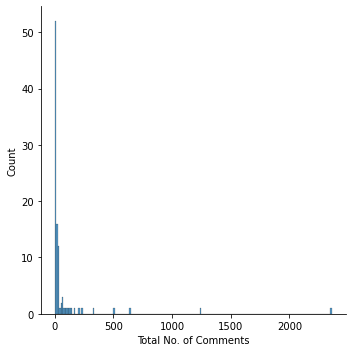

In [ ]:
import seaborn as sns
sns.displot(data = elections_df, x = 'Total No. of Comments')

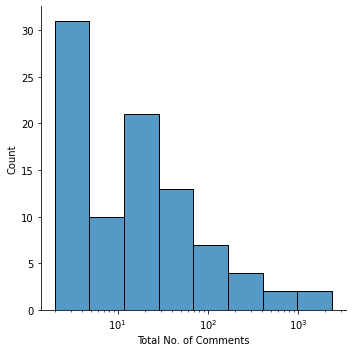

In [ ]:
# let's try in log scale

# first remove posts with non-zero comments
elections_df = elections_df[elections_df['Total No. of Comments'] > 0]
sns.displot(data = elections_df, x = 'Total No. of Comments', log_scale=True)